<Figure size 1800x1200 with 0 Axes>

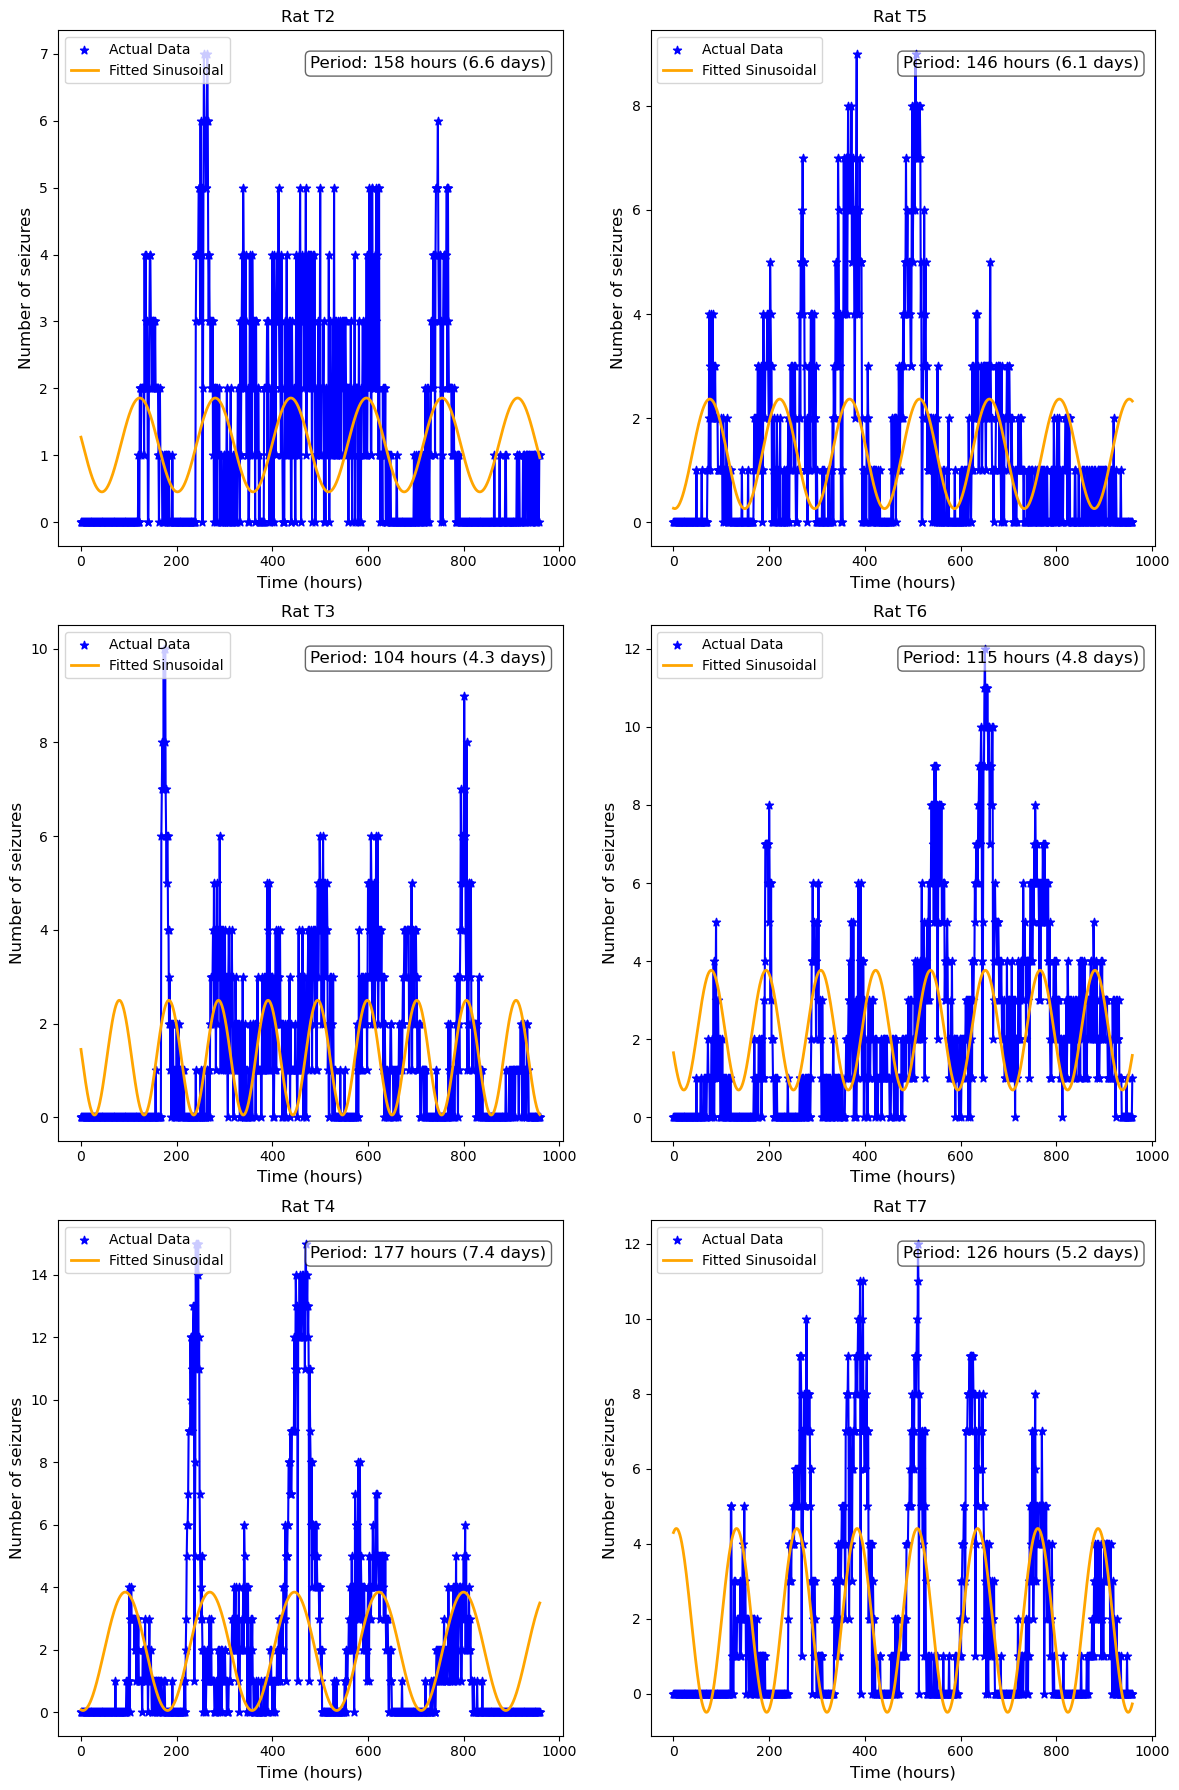

Periods found for Rat T1: 125.92423133247917


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.io import loadmat
import seaborn as sns


# Load the data from the MATLAB .mat file
mat_data = loadmat('All_counts.mat')

# Extract the All_counts data
All_counts = mat_data['All_counts']

# Set the figure size for the period plots
plt.figure(figsize=(18, 12))
font_size_tick = 12

def sinusoidal_func(x, A, omega, phi, c):
    return A * np.sin(omega * x + phi) + c

# Define a function to determine the maximum amplitude based on the data
def max_amplitude_func(data):
    return np.max(data) - np.min(data)  # Amplitude as the range of data

# Function to calculate the sum of squared residuals (SSR)
def calculate_ssr(y, y_fit):
    return np.sum((y - y_fit) ** 2)

# Function to calculate SI
def calculate_si_index(seizure_phases):
    # Convert seizure phases to floating-point numbers
      # Convert seizure phases to floating-point numbers
    seizure_phases_float = [float(phase) for phase in seizure_phases]
    complex_exponentials = np.exp(1j * np.array(seizure_phases_float))
    mean_resultant_vector = np.mean(complex_exponentials)
    SI = round(np.abs(mean_resultant_vector),2)
    
    return SI

# Define the number of hours in a 2-day period and the total number of hours in the dataset
hours_in_2_days = 24 * 40
total_hours = 24 * 40

# Define the number of segments
num_segments = total_hours // hours_in_2_days

# List of colors for plotting
colors = plt.cm.viridis(np.linspace(0, 1, len(All_counts[0])))
fit_colors = plt.cm.plasma(np.linspace(0, 1, len(All_counts[0])))

# Create a figure for the fitted curves on the first segment
fig1, axs1 = plt.subplots(3, 2, figsize=(12, 18))
#axs1 = axs1.flatten()

# Create a figure for the period plots
#fig2, axs2 = plt.subplots(6, 1, figsize=(9, 12))
#axs2 = axs2.flatten()

# Create a figure for the SI plots
#fig3, axs3 = plt.subplots(6, 1, figsize=(9, 12))
#axs3 = axs3.flatten()
# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)  # Increase the height space between subplots

# Set a color palette using seaborn
colors = sns.color_palette("husl", 6)
# Iterate over each rat's data
for rat_idx, rat_data in enumerate(All_counts[0], start=1):
    # Extract data for the current rat
    rat_data = All_counts[0][rat_idx - 1]  # Subtract 1 to account for 0-based indexing
    rat_data=rat_data.T
    # Flatten the 24x40 matrix into a 1D array
    data_num = rat_data.flatten()

    periods_over_time = []  # List to store periods for each segment
    si_indices_over_time = []  # List to store SI indices for each segment

    for segment in range(num_segments):
        # Extract the data for the current 2-day segment
        segment_start = segment * hours_in_2_days
        segment_end = segment_start + hours_in_2_days
        segment_data = data_num[segment_start:segment_end]

        x = np.arange(len(segment_data))

        # Initial guess ranges for the parameters
        amplitude_guess = max_amplitude_func(segment_data)
        omega_start = 2 * np.pi / 2  # Starting value for omega (period of 2 hour)
        omega_end = 2 * np.pi / (240)  # Ending value for omega (period of 28 hours)
        phi_start = 0  # Starting value for phase
        phi_end = 2 * np.pi  # Ending value for phase
        offset_guess = np.mean(segment_data)

        best_fit = None
        lowest_ssr = np.inf

        # Iterate over a range of initial guesses
        for omega in np.linspace(omega_end, omega_start, 100):  # Ensure omega is within the bounds
            for phi in np.linspace(phi_start, phi_end, 50):
                initial_guess = [amplitude_guess, omega, phi, offset_guess]

                try:
                    popt, _ = curve_fit(sinusoidal_func, x, segment_data, p0=initial_guess, bounds=([0, 2 * np.pi / (240), -np.inf, -np.inf], [np.inf, 2 * np.pi / 2, np.inf, np.inf]))
                    y_fit = sinusoidal_func(x, *popt)
                    ssr = calculate_ssr(segment_data, y_fit)

                    if ssr < lowest_ssr:
                        best_fit = popt
                        lowest_ssr = ssr

                except RuntimeError:
                    continue

        if best_fit is not None:
            # Calculate the period from the fitted parameters
            period = 2 * np.pi / best_fit[1]
            periods_over_time.append(period)

            # Calculate SI index for the current segment
            cycle_length = period
                # Convert seizure counts to timestamps
            seizure_timestamps = []
            for hour, count in enumerate(segment_data):
                seizure_timestamps.extend([hour] * count)
            phase_values = [(timestamp % cycle_length) * (2 * np.pi / cycle_length) for timestamp in seizure_timestamps]
            si_index = calculate_si_index(phase_values)
            si_indices_over_time.append(si_index)
            ax = axs1[(rat_idx - 1) % 3, (rat_idx - 1) // 3]

            # Plot the actual data and fitted sinusoidal for the first segment
            if segment == 0:
                ax.scatter(x, segment_data, color='blue', marker='*', label='Actual Data')  # Mark actual data points with stars
                ax.plot(x, segment_data, color='blue')
                # Generate a denser range of x values for smoother sinusoidal curve
                x_dense = np.linspace(x[0], x[-1], 1000)
                ax.plot(x_dense, sinusoidal_func(x_dense, *best_fit), label='Fitted Sinusoidal', color='orange', linewidth=2)  # Plot fitted sinusoidal
                ax.set_xlabel('Time (hours)', fontsize=font_size_tick)
                ax.set_ylabel('Number of seizures', fontsize=font_size_tick)
                ax.set_title(f'Rat T{rat_idx+1} ', fontsize=font_size_tick)

                # Add text annotation for the period
                period_text = f'Period: {round(period)} hours ({period/24:.1f} days)'
                bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.6)
                ax.text(0.5, 0.95, period_text, transform=ax.transAxes, fontsize=font_size_tick, verticalalignment='top', bbox=bbox_props)

                # Adjust legend position
                ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

   
plt.tight_layout()

fig2.tight_layout()  # Add padding to avoid overlap
fig1.savefig('cycles_sin_hours.png', dpi=300)

plt.show()

# Print periods found for each rat
for rat_idx, periods in enumerate(periods_over_time, start=1):
    print(f'Periods found for Rat T{rat_idx}: {periods}')
